In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import torch as t
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
import pickle
from tqdm.auto import tqdm
from utils.config import opt
from data.dataset import Dataset, TestDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


TRAIN_MODE = False

In [2]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

# Load model trained with caffe pretrained model

In [3]:
%ls ./checkpoints/cars

baseline_results.pickle                 gt_labels_test.pickle
fasterrcnn_04151829_0.6704369972064141  inv_mahal_cov.pickle
fasterrcnn_04151851_0.6877679369254311  kitti_features.pickle
fasterrcnn_04151914_0.7164561623943497  mahal_cov.pickle
fasterrcnn_04151958_0.7435728692746989  mahal_means.pickle
fasterrcnn_04152043_0.7459420675485349  mahal_result.pickle
fasterrcnn_04152235_0.7462277363985176  pred_bboxes_test.pickle
gt_bboxes_test.pickle                   pred_labels_test.pickle
gt_difficults_test.pickle               pred_scores_test.pickle
gt_labels.pickle                        tsne_features.pickle


In [4]:
save_dir = './checkpoints/cars'

trainer.load(os.path.join(save_dir, 'fasterrcnn_04152235_0.7462277363985176'))

FasterRCNNTrainer(
  (faster_rcnn): FasterRCNNVGG16(
    (extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPoo

In [5]:
img = read_image('misc/demo.jpg')
img = t.from_numpy(img)[None]

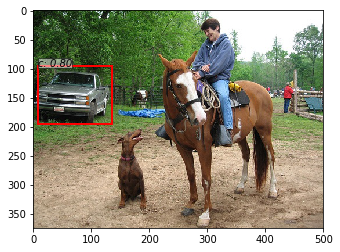

In [6]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)

vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# Display a Kitti image

In [7]:
dataset_dir = '/media/tadenoud/DATADisk/datasets/kitti_2d'  # School comp
# dataset_dir = '/home/tadenoud/Documents/kitti' # Laptop

img_paths = [
    os.path.join(dataset_dir, 'training/image_2/005009.png'),
    os.path.join(dataset_dir, 'training/image_2/005010.png')
]

imgs = np.array([read_image(p) for p in img_paths])

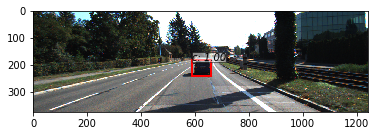

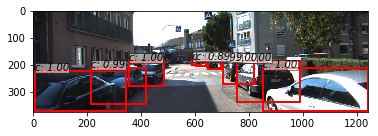

In [8]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(imgs,visualize=True)
vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

vis_bbox(at.tonumpy(imgs[1]),
         at.tonumpy(_bboxes[1]),
         at.tonumpy(_labels[1]).reshape(-1),
         at.tonumpy(_scores[1]).reshape(-1))

# Train mahalanobis features with entire training dataset

In [9]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = Dataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

if TRAIN_MODE:
    trainer.faster_rcnn.train_ood(dataloader)
    trainer.faster_rcnn.save_mahalanobis_features(save_dir=save_dir)
else:
    trainer.faster_rcnn.load_mahalanobis_features(save_dir=save_dir)

load data


In [10]:
if TRAIN_MODE:
    with open(os.path.join(save_dir, 'gt_labels.pickle'), 'wb') as f:
        pickle.dump(trainer.faster_rcnn.gt_labels, f)
# else:
    
with open(os.path.join(save_dir, 'gt_labels.pickle'), 'rb') as f:
    gt_labels = pickle.load(f)

In [11]:
VOC_BBOX_LABEL_NAMES = (
    'car',
    'van',
    'truck',
    'tram',
    'person',
    'person_sitting',
    'cyclist',
    'misc'
    # 'dontcare
)

for j in range(8):
    print(VOC_BBOX_LABEL_NAMES[j], "count:", sum([i == j for i in gt_labels]))

car count: 2602
van count: 0
truck count: 0
tram count: 0
person count: 0
person_sitting count: 0
cyclist count: 0
misc count: 0


# Visualize features using t-SNE

In [12]:
from time import time
from sklearn.manifold import TSNE

if TRAIN_MODE:
    print("Computing t-SNE embedding")
    tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=20)
    t0 = time()
    X_tsne = tsne.fit_transform(trainer.faster_rcnn.features)
    t1 = time()
    
    with open(os.path.join(save_dir, "tsne_features.pickle"), "wb") as f:
        pickle.dump(X_tsne, f)

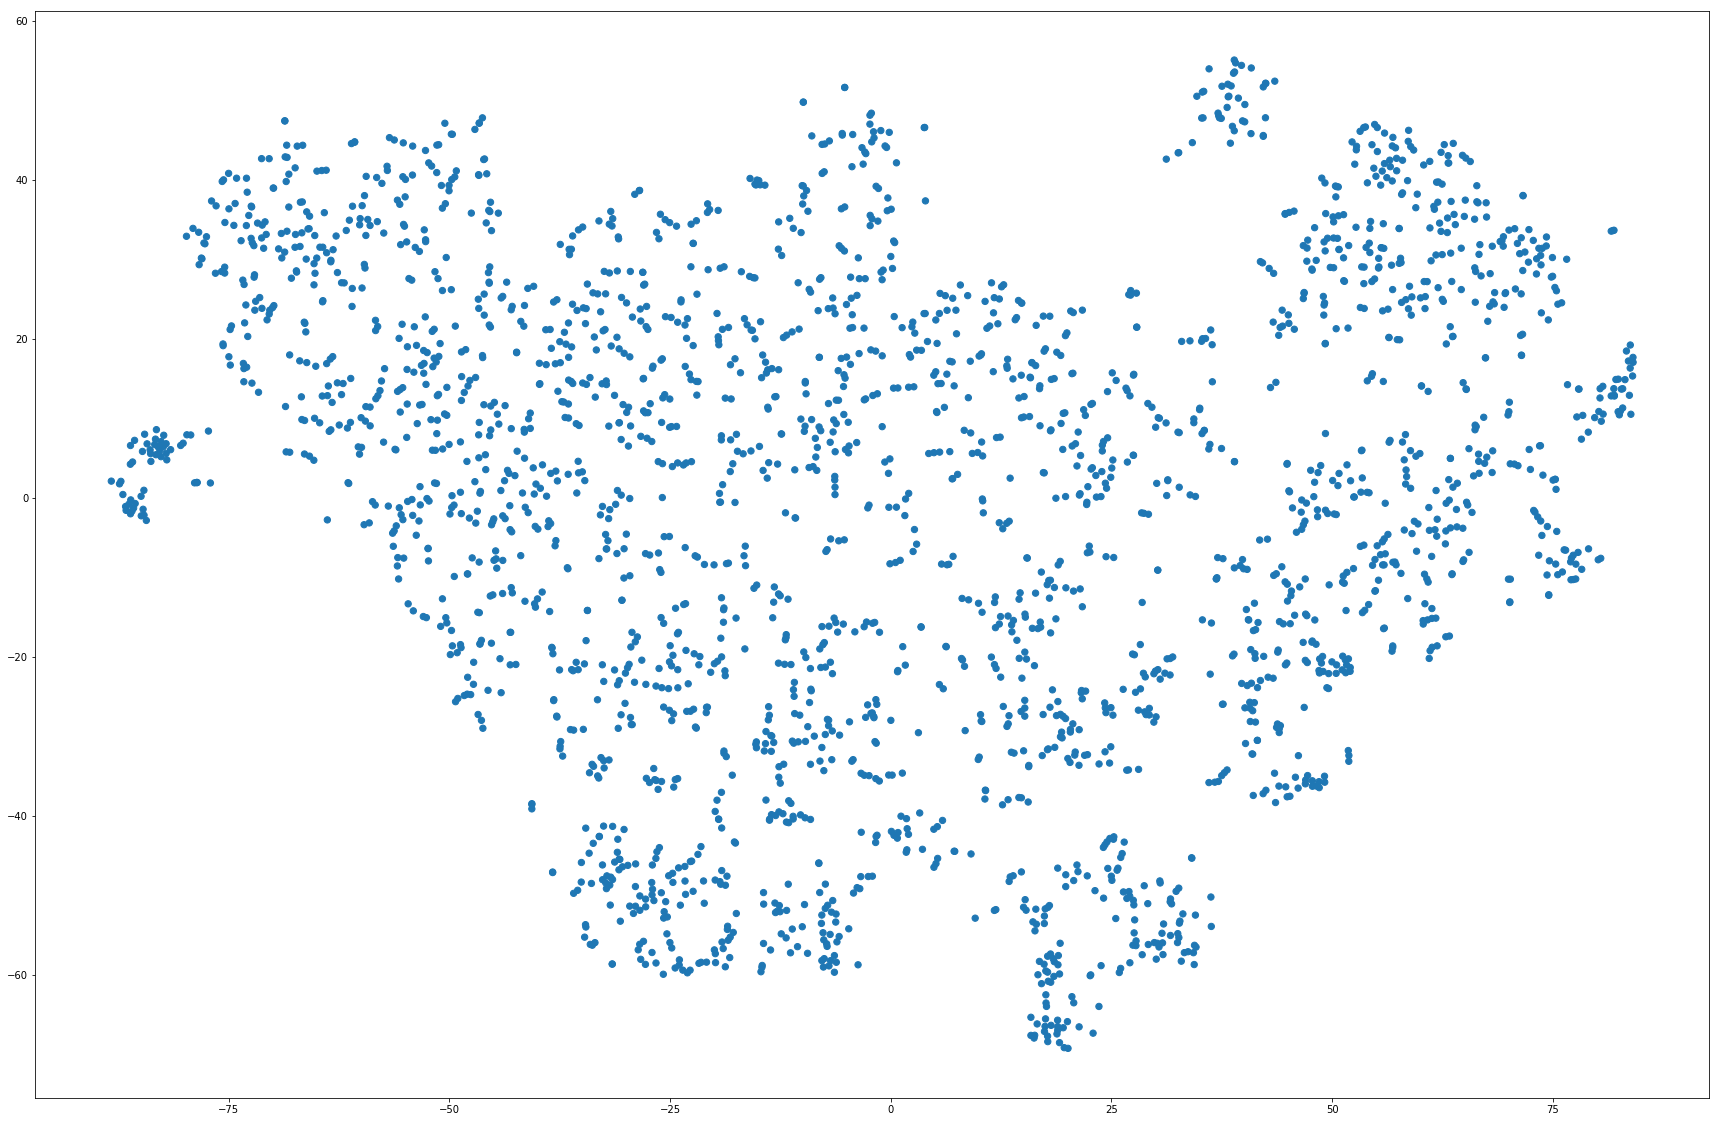

In [13]:
with open(os.path.join(save_dir, "tsne_features.pickle"), "rb") as f:
    X_tsne = pickle.load(f)

mask = (gt_labels != -1)
plt.figure(figsize=(30, 20))
plt.scatter(X_tsne[:,0][mask], X_tsne[:,1][mask], c=gt_labels[mask], s=40, cmap=plt.cm.get_cmap('tab10'))
plt.show()

# Predict class using features

In [14]:
# Evaluate baseline softmax method
from train import eval, eval_mahal

print('load data') 
test_dataset = TestDataset(opt)
test_dataloader = DataLoader(test_dataset,
                             batch_size=1,
                             shuffle=False,
                             pin_memory=True,
                             num_workers=opt.num_workers)

if TRAIN_MODE:
    baseline_result = eval(test_dataloader, trainer.faster_rcnn, test_num=opt.test_num)
    with open(os.path.join(save_dir, "baseline_results.pickle"), 'wb') as f:
        pickle.dump(baseline_result, f)
    
with open(os.path.join(save_dir, "baseline_results.pickle"), 'rb') as f:
    baseline_result = pickle.load(f)
    
print(baseline_result)

load data
{'map': 0.7462637677770373, 'ap': array([0.74626377])}


In [15]:
# Evaluate mahalanobis distance method

if TRAIN_MODE:
    mahal_result = eval_mahal(test_dataloader, trainer.faster_rcnn, test_num=opt.test_num)
    with open(os.path.join(save_dir, "mahal_result.pickle"), "wb") as f:
        pickle.dump(mahal_result, f)
else:    
    with open(os.path.join(save_dir, "mahal_result.pickle"), "rb") as f:
        mahal_result = pickle.load(f)
    
print(mahal_result)

{'map': 0.706200905443196, 'ap': array([0.70620091])}


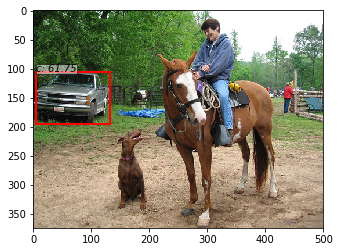

In [16]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(img,visualize=True)

vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0].reshape(-1)),
         at.tonumpy(_scores[0].reshape(-1)))

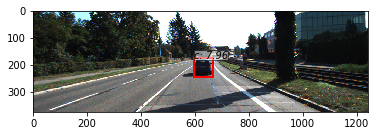

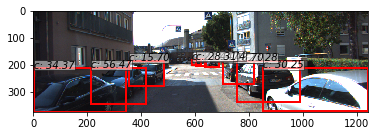

In [17]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(imgs,visualize=True)

vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

vis_bbox(at.tonumpy(imgs[1]),
         at.tonumpy(_bboxes[1]),
         at.tonumpy(_labels[1]).reshape(-1),
         at.tonumpy(_scores[1]).reshape(-1))

# Do some predictions of "weird car" images from Google

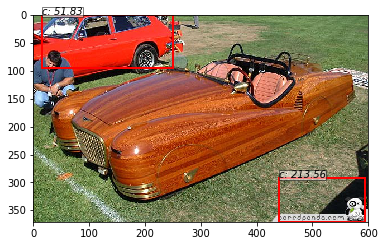

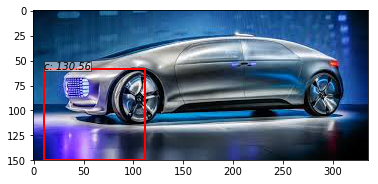

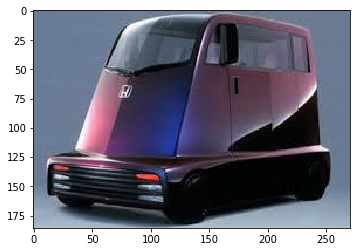

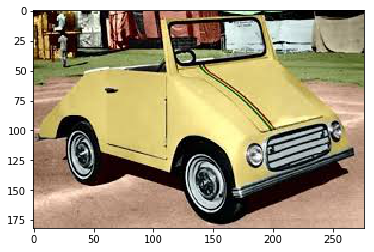

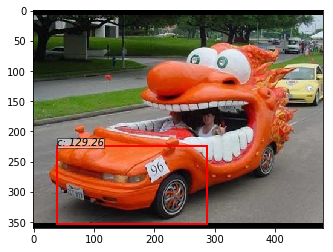

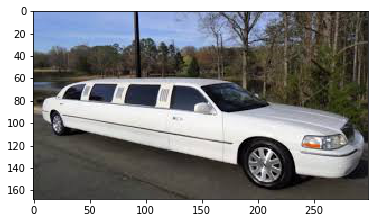

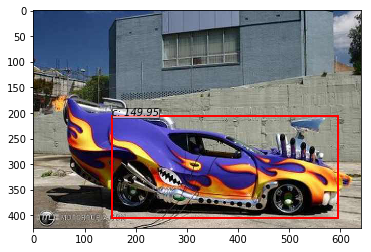

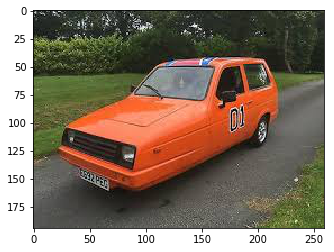

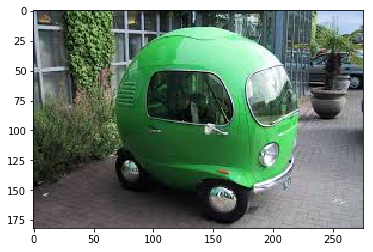

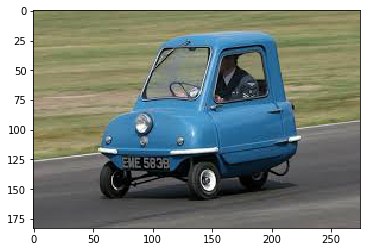

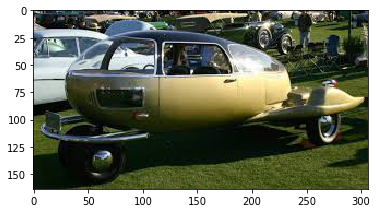

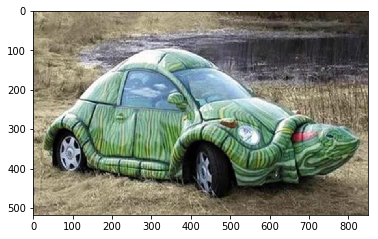

In [18]:
for img_name in os.listdir("./weird_cars"):
    img_path = os.path.join("./weird_cars", img_name)
    im = np.array(read_image(img_path))
    
    _bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis([im], visualize=True)
    
    vis_bbox(at.tonumpy(im),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# AUROC Mahalanobis on test data

In [27]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = TestDataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

In [28]:
if TRAIN_MODE:
    features = []
    gt_labels = []

    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader), total=opt.test_num):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict_mahalanobis(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        
    with open(os.path.join(save_dir, "gt_bboxes_test.pickle"), "wb") as f:
        pickle.dump(gt_bboxes, f)
    with open(os.path.join(save_dir, "gt_labels_test.pickle"), "wb") as f:
        pickle.dump(gt_labels, f)
    with open(os.path.join(save_dir, "gt_difficults_test.pickle"), "wb") as f:
        pickle.dump(gt_difficults, f)

    with open(os.path.join(save_dir, "pred_bboxes_test.pickle"), "wb") as f:
        pickle.dump(pred_bboxes, f)
    with open(os.path.join(save_dir, "pred_labels_test.pickle"), "wb") as f:
        pickle.dump(pred_labels, f)
    with open(os.path.join(save_dir, "pred_scores_test.pickle"), "wb") as f:
        pickle.dump(pred_scores, f)

else:
    with open(os.path.join(save_dir, "gt_bboxes_test.pickle"), "rb") as f:
        gt_bboxes= pickle.load(f)
    with open(os.path.join(save_dir, "gt_labels_test.pickle"), "rb") as f:
        gt_labels = pickle.load(f)
    with open(os.path.join(save_dir, "gt_difficults_test.pickle"), "rb") as f:
        gt_difficults = pickle.load(f)

    with open(os.path.join(save_dir, "pred_bboxes_test.pickle"), "rb") as f:
        pred_bboxes = pickle.load(f)
    with open(os.path.join(save_dir, "pred_labels_test.pickle"), "rb") as f:
        pred_labels = pickle.load(f)
    with open(os.path.join(save_dir, "pred_scores_test.pickle"), "rb") as f:
        pred_scores = pickle.load(f)

100%|██████████| 3578/3578 [27:37<00:00,  2.15it/s]


In [29]:
IOU_THRESH = 0.5

from model.utils.bbox_tools import bbox_iou

# Ground truth bboxes
print("Ground truth bboxes:", len(np.concatenate(gt_bboxes)))

# Pred bboxes
print("Pred bboxes:", len(np.concatenate(pred_bboxes)))


# Loop through results by image
bboxes_ious = list()
overlapping_bboxes = list()
correct_classification = list()

def iou(bbox, label, gt_boxes, gt_labels, iou_thresh=0.5):
    if not len(gt_labels):
        return 0, False
    try:
        ious = bbox_iou(np.array([bbox]), gt_boxes)
        best_iou = np.max(ious)
        best_label = gt_labels[np.argmax(ious)]
        
    except ValueError:
        import pdb; pdb.set_trace()
    return best_iou, best_iou > 0 and best_label == label
            

for gt_bbox, gt_label, pred_bbox, pred_label, pred_score in \
        zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores):
    # Calculate if the pred bbox has an overlapping gt_bbox
    bboxes_ious.append([])
    overlapping_bboxes.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        bbox_iou_score, correct_class = iou(bbox, label, gt_bbox, gt_label)
            
        bboxes_ious[-1].append(bbox_iou_score)
        overlapping_bboxes[-1].append(bbox_iou_score > IOU_THRESH)
        correct_classification[-1].append(correct_class)

Ground truth bboxes: 20281
Pred bboxes: 29035


In [30]:
from itertools import chain
from metrics import barcode_plot, fpr_at_95_tpr, auroc, detection_error

scores = list(chain(*pred_scores))
overlap_correct = list(chain(*overlapping_bboxes))
class_correct = list(chain(*correct_classification))
both_correct = [a and b for a, b in zip(overlap_correct, class_correct)]

print("AUROC")
print("Overlap", auroc(scores, overlap_correct))
print("Class", auroc(scores, class_correct))
print("Both", auroc(scores, both_correct))
print()
print("FPR@95TPR")
print("Overlap", fpr_at_95_tpr(scores, overlap_correct))
print("Class", fpr_at_95_tpr(scores, class_correct))
print("Both", fpr_at_95_tpr(scores, both_correct))
print()
print("Detection Err")
print("Overlap", detection_error(scores, overlap_correct))
print("Class", detection_error(scores, class_correct))
print("Both", detection_error(scores, both_correct))

AUROC
Overlap 0.09730847955752692
Class 0.26945206332504706
Both 0.09046422536323924

FPR@95TPR
Overlap 0.999350879263543
Class 0.9982620785540494
Both 0.9993672706356054

Detection Err
Overlap 0.5231678707675147
Class 0.5240655352179207
Both 0.5240613177212361


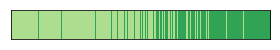

In [31]:
from metrics import barcode_plot, fpr_at_95_tpr, auroc
barcode_plot([-a for a in scores], both_correct)

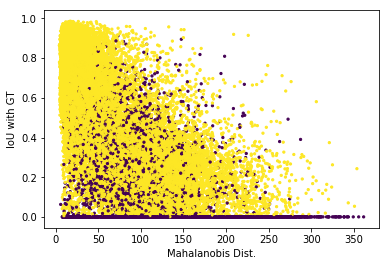

In [32]:
# Mahalanobis score vs IoU vs correct classificationplt.figure()
plt.scatter(scores, list(chain(*bboxes_ious)), c=class_correct, cmap='viridis', s=5)
plt.xlabel("Mahalanobis Dist.")
plt.ylabel("IoU with GT")
plt.show()

# AUROC Max Softmax on test data

In [33]:
opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = TestDataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

In [35]:
if TRAIN_MODE:
    features = []
    gt_labels = []

    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader), total=opt.test_num):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_

    with open(os.path.join(save_dir, "pred_bboxes_test_softmax.pickle"), "wb") as f:
        pickle.dump(pred_bboxes, f)
    with open(os.path.join(save_dir, "pred_labels_test_softmax.pickle"), "wb") as f:
        pickle.dump(pred_labels, f)
    with open(os.path.join(save_dir, "pred_scores_test_softmax.pickle"), "wb") as f:
        pickle.dump(pred_scores, f)

else:
    with open(os.path.join(save_dir, "pred_bboxes_test_softmax.pickle"), "rb") as f:
        pred_bboxes = pickle.load(f)
    with open(os.path.join(save_dir, "pred_labels_test_softmax.pickle"), "rb") as f:
        pred_labels = pickle.load(f)
    with open(os.path.join(save_dir, "pred_scores_test_softmax.pickle"), "rb") as f:
        pred_scores = pickle.load(f)
        
with open(os.path.join(save_dir, "gt_bboxes_test.pickle"), "rb") as f:
    gt_bboxes = pickle.load(f)
with open(os.path.join(save_dir, "gt_labels_test.pickle"), "rb") as f:
    gt_labels = pickle.load(f)
with open(os.path.join(save_dir, "gt_difficults_test.pickle"), "rb") as f:
    gt_difficults = pickle.load(f)

In [36]:
from model.utils.bbox_tools import bbox_iou

# Ground truth bboxes
print("Ground truth bboxes:", len(np.concatenate(gt_bboxes)))

# Pred bboxes
print("Pred bboxes:", len(np.concatenate(pred_bboxes)))

# Loop through results by image
bboxes_ious = list()
overlapping_bboxes = list()
correct_classification = list()

for gt_bbox, gt_label, pred_bbox, pred_label, pred_score in \
        zip(gt_bboxes, gt_labels, pred_bboxes, pred_labels, pred_scores):
    # Calculate if the pred bbox has an overlapping gt_bbox
    bboxes_ious.append([])
    overlapping_bboxes.append([])
    correct_classification.append([])
    for bbox, label, score in zip(pred_bbox, pred_label, pred_score):
        bbox_iou_score, correct_class = iou(bbox, label, gt_bbox, gt_label)
        
        bboxes_ious[-1].append(bbox_iou_score)
        overlapping_bboxes[-1].append(bbox_iou_score > IOU_THRESH)
        correct_classification[-1].append(correct_class)

Ground truth bboxes: 20281
Pred bboxes: 20642


In [37]:
from itertools import chain
from sklearn.metrics import roc_auc_score

scores = list(chain(*pred_scores))
overlap_correct = list(chain(*overlapping_bboxes))
class_correct = list(chain(*correct_classification))
both_correct = [a and b for a, b in zip(overlap_correct, class_correct)]

print("AUROC")
print("Overlap", auroc(scores, overlap_correct))
print("Class", auroc(scores, class_correct))
print("Both", auroc(scores, both_correct))
print()
print("FPR@95TPR")
print("Overlap", fpr_at_95_tpr(scores, overlap_correct))
print("Class", fpr_at_95_tpr(scores, class_correct))
print("Both", fpr_at_95_tpr(scores, both_correct))
print()
print("Detection Err")
print("Overlap", detection_error(scores, overlap_correct))
print("Class", detection_error(scores, class_correct))
print("Both", detection_error(scores, both_correct))

AUROC
Overlap 0.9189446078987684
Class 0.7885422966127595
Both 0.9294091436700177

FPR@95TPR
Overlap 0.4137038703870387
Class 0.8587904360056259
Both 0.34178444276620995

Detection Err
Overlap 0.23182215809636092
Class 0.45438497629859337
Both 0.1958196811562519


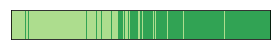

In [38]:
from metrics import barcode_plot
barcode_plot(scores, both_correct)

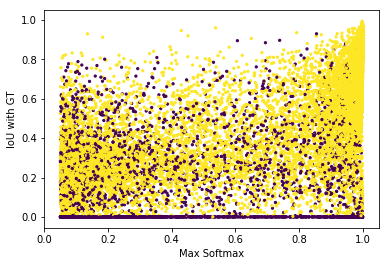

In [39]:
# Softmax score vs IoU vs correct classification
plt.figure()
plt.scatter(scores, list(chain(*bboxes_ious)), c=class_correct, cmap='viridis', s=5)
plt.xlabel("Max Softmax")
plt.ylabel("IoU with GT")
plt.show()

In [41]:
with open(os.path.join(save_dir, "pred_scores_test_softmax.pickle"), "rb") as f:
    softmax_scores = pickle.load(f)
    softmax_scores = list(chain(*softmax_scores))
        
with open(os.path.join(save_dir, "pred_scores_test.pickle"), "rb") as f:
    mahal_scores = pickle.load(f)
    mahal_scores = list(chain(*mahal_scores))

ValueError: x and y must be the same size

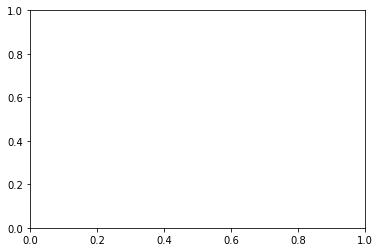

In [42]:
# Mahalanobis score vs Softmax score vs IoU
plt.figure()
plt.scatter(softmax_scores, mahal_scores, c=list(chain(*bboxes_ious)), cmap='viridis', s=5)
plt.xlabel("Mahalanobis Dist.")
plt.ylabel("Max Softmax")
leg = plt.colorbar()
leg.set_label("IoU with GT")
plt.show()